# Final Project
Travis Zhang and Lauren Greenhill

## Problem Statement
Many prominent CEOs and leaders hold public social media accounts to convey their, and their activity on social media can oftentimes affect the reputation of him/her and the company he/she represents. Elon Musk, a leader known for his active presence on social media, particularly Twitter, has frequently written controversial Tweets that have affected Tesla’s stock.

## Hypothesis
We hypothesize that there is correlation between Elon’s Tweets and Tesla Stock.

## Data Processing
We could not find a dataset that fit exactly what we were looking for, so we decided to create our own using Tweepy, a Twitter API and yfinance, a python module for the deprecated Yahoo Finance API. One shortcoming of our project is the lack of data we were able to gather. The Twitter API limits users to apprximately 3500 tweets. The Yahoo Finance API only provides stock data by day.

### Twitter Data
From Twitter we were able to gather data on all of Elon Musk’s tweets from January 25, 2020 to November 22, 2020. For each tweet we logged the creation data, content of the tweet, the number of retweets, and the number of favorites. 
- Twitter data scraping code: https://github.com/ljgreenhill/ElonAnalysis/blob/main/twitterAPI.py
- CSV of data: https://github.com/ljgreenhill/ElonAnalysis/blob/main/data/tweets.csv

We then ran these tweets through a pretrained sentiment analyzer. 
- Sentiment analysis code: https://github.com/ljgreenhill/ElonAnalysis/blob/main/Sentiment%20Analysis.ipynb
- CSV of data: https://github.com/ljgreenhill/ElonAnalysis/blob/main/data/sentiment.csv

### Stock Data
The stock data gathered from Yahoo Finance ranged from June 29, 2010 to November 20, 2020, and the data included Open prices, Close prices, Low prices, High prices, Volume, Dividends, and Stock Splits. For our project, because we were limited by the
Twitter data, we had to restrict our stock data to the same dates. We calculated the change in prices per day when the market was open by subtracting the stock price when the market closed with the stock price when the market opened.
- Code to pull stock data and combine with twitter data: https://github.com/ljgreenhill/ElonAnalysis/blob/main/Dataset%20Retrieval.ipynb
- Combined CSV: https://github.com/ljgreenhill/ElonAnalysis/blob/main/data/elon.csv

## Regression
Inititally, we attempted to predict the change in stock price using regression models. 

### Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

data = pd.read_csv('data/sentiment.csv', index_col=0)
data = data.drop(columns=['Text'])
data.head()

,Change In Price,Favorites,Retweets,Negative,Neutral,Positive,Compound
2020-01-27,3.205994,6544.600000,814.000000,0.028,0.863,0.109,0.7959
2020-01-28,-0.318001,79576.500000,6452.666667,0.000,0.829,0.171,0.8718
2020-01-29,1.059998,35996.769231,4025.000000,0.027,0.755,0.218,0.9715
2020-01-30,1.678001,53946.166667,4608.000000,0.108,0.868,0.024,-0.5707
2020-01-31,2.113998,53814.944444,5062.500000,0.040,0.757,0.203,0.9657


### Linear Regression Model
We decided to start with a linear regression model. 

In [2]:
model = LinearRegression()
X = data[["Favorites", "Retweets", "Negative", "Positive", "Compound"]]
Y = data["Change In Price"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

model.fit(x_train, y_train)

predictions = model.predict(x_test)
error = mean_squared_error(y_test, predictions) 
print(error)

96.12167769618084


We then graphed this data in an attempt to determine if the model was over or underfitting. We found that it was underfitting.

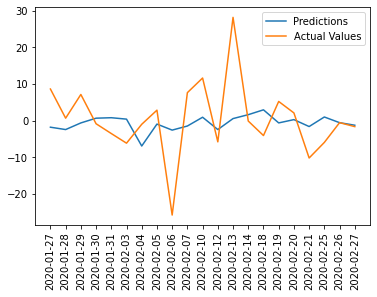

In [3]:
plt.plot(data.index[:len(predictions)], predictions)
plt.plot(data.index[:len(y_test)], y_test)
plt.xticks(rotation=90)
plt.legend(["Predictions","Actual Values"])
plt.show()

### Random Forest Regressor
We assumed that the Linear Regression model was underfitting because of a lack of data, we decided to try a Random Forest Regressor that included a bootstrap parameter.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X = data[["Favorites", "Retweets", "Negative", "Neutral", "Positive", "Compound"]]
Y = data["Change In Price"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
rf = RandomForestRegressor(n_estimators = 10000, random_state=0, bootstrap=True)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
error = mean_squared_error(y_test, predictions) 
print(error)

114.14753454891671


Again, the model underfitted.

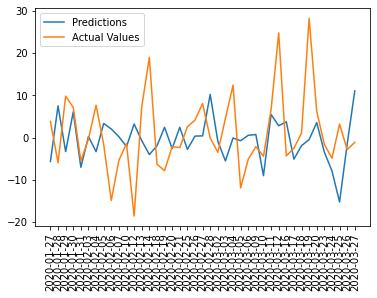

In [6]:
plt.plot(data.index[:len(predictions)], predictions)
plt.plot(data.index[:len(y_test)], y_test)
plt.xticks(rotation=90)
plt.legend(["Predictions","Actual Values"])
plt.show()

## Classification
Due to the large error in the regression models, we decided to try predicting whether the stock price went up or down because we thought this was an easier problem.

### Setup

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

data = pd.read_csv('data/sentiment.csv', index_col=0)
data = data.drop(columns=['Text'])
data["Change"] = np.where(data["Change In Price"]>0,1,0)
data["Change In Price"] = data["Change In Price"].abs()
data["Retweets*Neg"] = data["Retweets"]*data["Negative"]
data["Retweets*Pos"] = data["Retweets"]*data["Positive"]
data.head()

,Change In Price,Favorites,Retweets,Negative,Neutral,Positive,Compound,Change,Retweets*Neg,Retweets*Pos
2020-01-27,3.205994,6544.600000,814.000000,0.028,0.863,0.109,0.7959,1,22.792,88.7260
2020-01-28,0.318001,79576.500000,6452.666667,0.000,0.829,0.171,0.8718,0,0.000,1103.4060
2020-01-29,1.059998,35996.769231,4025.000000,0.027,0.755,0.218,0.9715,1,108.675,877.4500
2020-01-30,1.678001,53946.166667,4608.000000,0.108,0.868,0.024,-0.5707,1,497.664,110.5920
2020-01-31,2.113998,53814.944444,5062.500000,0.040,0.757,0.203,0.9657,1,202.500,1027.6875


### Normalization
Based on advice we received in office hours, we decided to scale and center our data. We also experimented with removing the compound feature from the sentiment analysis and including two new features (the number of retweets multipled by the positive rating from the sentiment analysis and the number of retweets multipled by the negative rating from the sentiment analysis). We did this because the more polarizing a tweet is the more retweets it should get. These kinds of tweets should impact the stock price more.

In [10]:
X = data[["Favorites", "Retweets", "Negative", "Positive", "Retweets*Neg", "Retweets*Pos"]]
Y = data["Change"]
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
print(X)

[[-0.22753503 -0.14847375 -0.29977882 -0.32016152 -0.07510093 -0.46178588]
 [ 0.39485523  0.10558221 -0.70972781  0.38502717 -0.07660067  1.45045092]
 [ 0.02346136 -0.00379882 -0.31441986  0.9196057  -0.06944973  1.02462073]
 ...
 [-0.15774485 -0.16225864 -0.46083021 -0.61588582 -0.07603236 -0.54952747]
 [-0.26031564 -0.18056593 -0.372984    1.20395598 -0.07644672 -0.58241027]
 [-0.22954115 -0.17562752 -0.28513778  0.43052322 -0.0761974  -0.55929863]]


### KNeighbors Classifer
First we tried Knearest neighbors with little success.

In [15]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.47761194029850745

### Decision Tree Classifier
After that we attempted a decision tree classifier, also with little success.

In [16]:
# Creates the Decision Tree Classifier
model=tree.DecisionTreeClassifier(max_depth=2)

#TODO: train the model
model.fit(x_train,y_train)
model.score(x_test, y_test)

0.5223880597014925

### Logistic Regression
Based on advice we received in office hours, we used the Logistic Regression model decision function to see which features were having the greatest impact on the model in an attempt to see which ones should be removed/weighted more heavily.

In [17]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print(clf.decision_function(X))
clf.score(x_test, y_test)

[-5.26649864e-03 -5.83229533e-01 -3.59745290e-01 -1.17786136e-01
 -4.55374810e-01 -2.21238009e-02 -1.92528471e-01 -1.03104201e-01
 -1.10673196e-01 -7.93404525e-02 -4.15266658e-03 -2.27776525e-01
 -2.10896582e-01 -1.15411626e-01 -3.73906772e-02 -2.11807756e-01
  5.87361540e-02 -9.77767698e-01 -3.98049734e-01 -4.23196670e-02
  2.01899920e-03  1.08177986e-02 -7.45325610e-02 -7.11725298e-01
 -5.58144938e-02  5.54546175e-02  3.29041987e+00  9.50459819e-02
 -4.08948907e-01 -3.08185117e-01 -1.43186045e-02  1.05006768e-02
 -5.15880720e-02 -2.93080649e-02 -1.60236550e-02 -2.39537757e-02
  1.29305135e-02 -1.42213651e-01 -6.04647953e-03  1.49206566e-02
 -1.06496461e-01 -1.49570881e-01 -3.29278204e-01 -3.76472455e-02
  1.77533537e-02  8.88653653e-03 -4.59005670e-02 -4.83817385e-02
 -1.34276507e-02 -6.61563443e-02 -4.73298957e-01 -1.13877811e-01
 -3.71382148e-02 -3.75716030e-02  3.87559015e-02 -4.54425198e-02
 -6.82231401e-02 -8.33166969e-02 -4.96927525e-02  5.07966262e-02
 -5.79958044e-02  8.09768

0.4925373134328358

## Conclusion
Ultimately, we were unable to prove a correlation between Elons' tweets and Tesla stock price. However, we believe this is due to a view issues in the way we process the data. The primary issue is the lack of data. The secondary issue is that because we look at stock price by day and therefore tweets by day, if Elon tweets a negative tweet and a positive tweet in the same day the sentiment analysis for each tweet cancels out. We found this to be the case most days.